# Chapter 8. Dimensionality Reduction (降維)

Project Goal: 維度災難, 降維法 (投射, 流形學習, PCA, Kernel PCA, LLE)

許多機器學習的任務都會有上百萬個特徵, 這些特徵會導致訓練速度極為緩慢, 稱為 維度災難 (curse of dimensionality), 所以我們需要大幅減少特徵數量(移除或合併)

# 投射降維法

在大多數的真實問題中, 訓練實例通常都有許多特徵幾乎是固定的, 其他則高度相關, 所以 透過將實例投影到維數較低的子空間中(例如 3D資料投影到2D平面上), 便可以達到降維的效果。但投射不一定會是降維最好的方法, 例如 如果資料分布是平躺的圓柱形(瑞士捲的樣子), 那就可能在投影的時候把資料都壓在一起

# 流形學習 (Manifold Learning)

上述瑞士捲的形狀其實稱為 2D流形 (manifold), 是在高維空間中彎曲或扭曲的2D形狀, 現實中大多數的高維資料組都接近一個維數低很多的流形, 處理方式也就是把它攤平

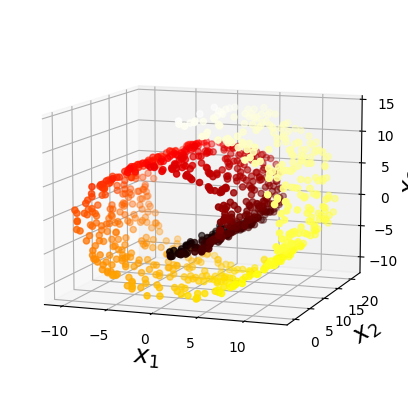

In [18]:
# 瑞士捲形狀
from sklearn.datasets import make_swiss_roll
import matplotlib as mpl
import matplotlib.pyplot as plt

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
plt.show()

# PCA (Principal Component Analysis, 主成分分析)

PCA 會先找出最接近資料的超平面, 再將資料投影上去, 而 最接近資料的超平面有兩個特徵, (1) 可以保留資料之間的最大變異度, (2) 原始資料與投影軸之間的距離最小

在2D資料空間中, 會先找出變異度最大的軸 (稱為第1個PC), 再找出與之垂直的第二PC, 若是高維則繼續類推

In [1]:
# 以3D資料為例

import numpy as np
np.random.seed(42)

m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
# SVD (Singular Value Decomposition, 奇異值分解), 將訓練組矩陣 X, 分解為 U Σ V^T
# 其中 V 包含許多單位向量, 這些向量定義我們想要找到的所有PC

# 因為 PCA 假設資料組的中心是原點, 所以需要減去 X.mean 來置中
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]                        # 三維資料中, c1 就是第1個PC
c2 = Vt.T[:, 1]                        # c2 就是第2個PC

In [5]:
# 若要將資料投影到 d維 平面上, 即 將X矩陣乘以V的前d欄
W2 = Vt.T[:, :2]               # W2 就是 V的前2欄
X2D = X_centered.dot(W2)       # X ⋅ W2 就是將資料投影到 2D 平面的結果
X2D_using_SVD = X2D

In [9]:
# 另外一種方法是 Scikit-Learn 中的 PCA
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

print("X2D with SVD:\n", X2D_using_SVD[:5])
print("X2D with PCA:\n", X2D[:5])

# 有時候 SVD 跟 PCA 的值有些會正負號不同, 就是向量方向的差異而已, 是正常的

X2D with SVD:
 [[-0.690074   -0.36150744]
 [ 1.39636097  0.34497714]
 [ 1.00728461 -0.35025708]
 [ 0.2736333  -0.50516373]
 [-0.91324535  0.26290852]]
X2D with PCA:
 [[-0.690074   -0.36150744]
 [ 1.39636097  0.34497714]
 [ 1.00728461 -0.35025708]
 [ 0.2736333  -0.50516373]
 [-0.91324535  0.26290852]]


In [12]:
# 將 投影後的2D結果再 inverse transform 回3D, 還會相同嗎?
# 當然不會, 因為已經損失一些維度上的資料了
X3D_inv = pca.inverse_transform(X2D)
print("Similar after inverse transform? ", np.allclose(X3D_inv, X))
print("Reconstruction Error =", np.mean(np.sum(np.square(X3D_inv - X), axis=1)))

# 其實 inverse_transform 就是 X2D_using_SVD.dot(Vt[:2, :])

Similar after inverse transform?  False
Reconstruction Error = 0.009421417196957216


In [13]:
# 查看 PC
print("PC using PCA:\n", pca.components_)
print("PC using SVD:\n", Vt[:2])
# 兩者的結果就是2D平面上的PC（值可能正負號會不同, 就是向量方向的差異而已）

PC using PCA:
 [[-0.95250178 -0.24902446 -0.17529172]
 [ 0.29267159 -0.9076305  -0.30091563]]
PC using SVD:
 [[-0.95250178 -0.24902446 -0.17529172]
 [ 0.29267159 -0.9076305  -0.30091563]]


Explained Variance Ratio (已解釋變異比)

In [14]:
print(pca.explained_variance_ratio_)
# 得到的結果代表第一PC包含了資料組 85.4% 的變異度, 第二PC 包含 13.6% 的變異度
# 也就是如果還有第三PC, 他應該只占據不到 1.0% 的少量變異度

[0.85406025 0.13622918]


如何選擇正確的維度？

In [16]:
# 可以先找出加起來包含大多數變異度的維數(例如95%)

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print("Prefer number of PCs: ", d)

# 由結果的154可以得知, 我們能把原先784個特徵降低到154個, 如此就可以大幅減少訓練的時間

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Prefer number of PCs:  154


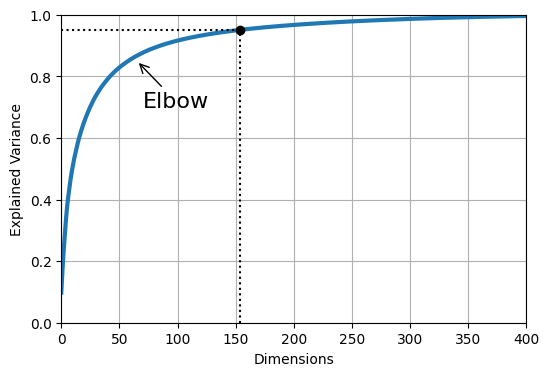

In [17]:
# 或是可以透過圖像來觀察
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

# 由下圖可以發現, 維度100左右其實就已經包含大多數的資料變異度了
# 選擇100維也不會損失太多的已解釋變異度

以PCA來壓縮資料

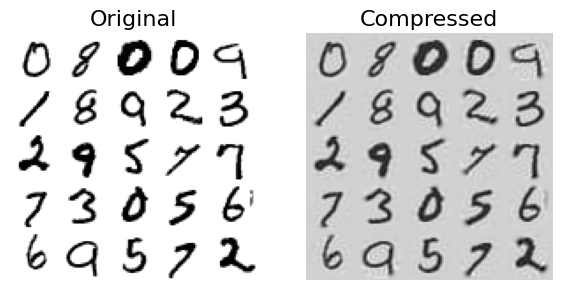

In [22]:
# 既然154維就可以解釋95%的變異度, 那我們可以利用這154維的PC去重建原先資料集
# 如此一來, 資料組特徵變少的同時, 也可以保留大部分重要的特徵!

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
X_reduced_pca = X_reduced

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)
plt.show()

# 由下圖可見, 壓縮前與壓縮後的圖片相差不多, 但特徵量減少了將近80%, 這就是壓縮的意義
# X_recovered = X_d_proj ⋅ W_d^T (復原的X = 投射到d維的X ⋅ 前d個PC的向量)

# Randomized PCA

In [24]:
# 如果將 PCA 的 svd_solver 設為 randomized, 
# Scikit-Learn 會用隨機演算法快速找到PCA的近似值, 而不是完整的SVD演算法
# 當維數遠小於特徵數時, 速度會快很多

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# Incremental PCA

In [25]:
# 但前面提到的PCA做法都有一個問題, 就是 必須將整個訓練組都放入記憶體才能執行
# 使用 Incremental PCA, 會把訓練組拆成小batch, 一一傳給 IPCA 演算法

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
# 用 np.array_split() 把訓練組拆成 batches
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

# PCA v.s. Randomized PCA v.s. Incremental PCA

In [26]:
# 比較在不同 n_components 的執行時間

import time

for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver="randomized")

    for name, pca in (("PCA", regular_pca), ("Inc PCA", inc_pca), ("Rnd PCA", rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(name, t2 - t1))

# 由結果可以觀察到:
# IPCA 花的時間最長, 因為訓練組是一批一批傳的 (節省記憶體空間的trade-off)
# 在 n_components 遠小於特徵數時, Randomized PCA 會相對較快 (理論上應該都要比一般PCA快)

n_components = 2
    PCA: 5.3 seconds
    Inc PCA: 14.4 seconds
    Rnd PCA: 3.5 seconds
n_components = 10
    PCA: 4.6 seconds
    Inc PCA: 14.6 seconds
    Rnd PCA: 6.8 seconds
n_components = 154
    PCA: 4.9 seconds
    Inc PCA: 21.7 seconds
    Rnd PCA: 7.3 seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

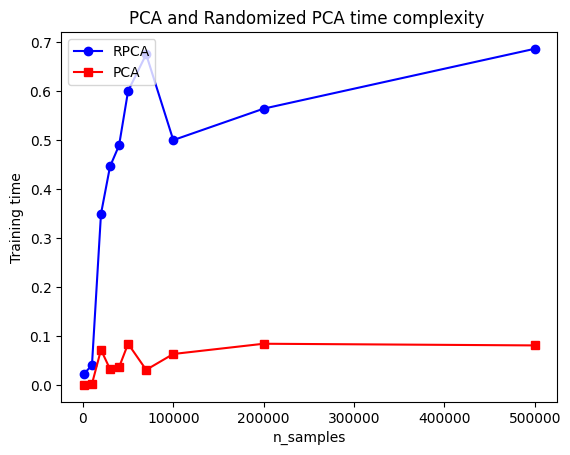

In [27]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# 由下圖可見, 在不同資料數下, Randomized PCA 大致都會比 一般PCA 慢

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

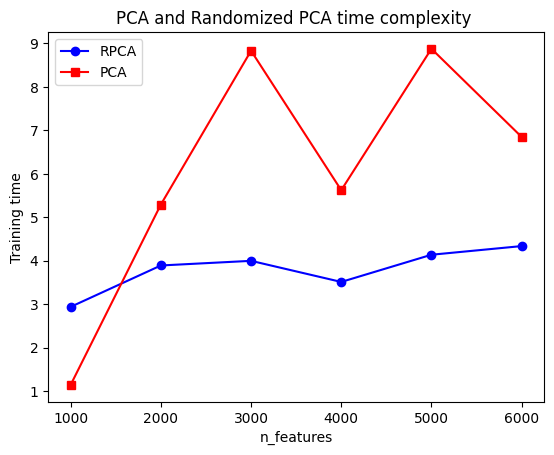

In [28]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# 由下圖可知, 在相同資料數但不同特徵數下, Randomized PCA 大致上都會比 一般PCA 快

# Kernel PCA

在前面章節中有提到, 高維空間的線性決策邊界, 其實就是原始空間中的複雜非線性決策邊界, 利用此原理, 我們可以在降維時, 做複雜的非線性投射, 讓投射後仍保留資料的群聚特性

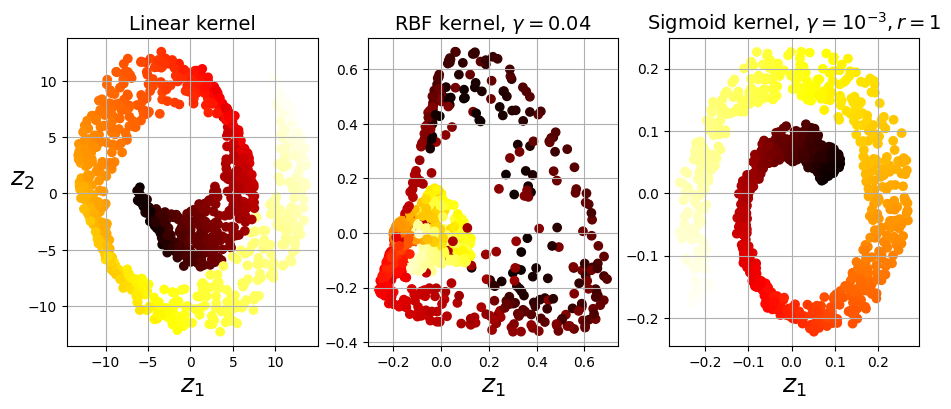

In [29]:
# 利用三種不同的 Kernel 把瑞士捲降成二維
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced

    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

# For reference, 不同的 Kernel 差別如下:
# Linear Kernel :  𝐾(𝑋,𝑌) = 𝑋^𝑇 ⋅ 𝑌
# RBF Kernel    :  𝐾(𝑋,𝑌) = exp(−γ ⋅ ‖𝑋−𝑌‖^2)
# Sigmoid Kernel:  𝐾(𝑋,𝑌) = tanh(γ ⋅ 𝑋^𝑇 ⋅ 𝑌 + 𝑟)

如何找出最好的參數？

In [30]:
# 第一種方法是, 一樣可以利用 GridSearchCV 來找到最好的參數組合
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 先降成二維, 再執行 Logistic Regression
clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)), 
    ("log_reg", LogisticRegression())
])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print("Best result:", grid_search.best_params_)

Best result: {'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [32]:
# 第二種方法是, 選出 reconstruction error 最低的kerenl與參數
# 例如三維空間的瑞士捲, 降到二維之後再放回三維空間中, 就會變成三維空間中的二維平面
# 這就是重構 (pre-image), 誤差即是計算它與原始實例的距離平方, 目標是選出讓它最小化的參數

from sklearn.metrics import mean_squared_error

rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

print("MSE =", mean_squared_error(X, X_preimage))

MSE = 32.78630879576611


# LLE (Locally Linear Embedding, 局部線性嵌入)

LLE 是一種非線性降維的流形學習技術, 與前者使用投射不同, 它會先評估各個訓練實例與其最接近的鄰點之間的線性相關性, 再尋找最能夠保留這些局部關係的低維表示法

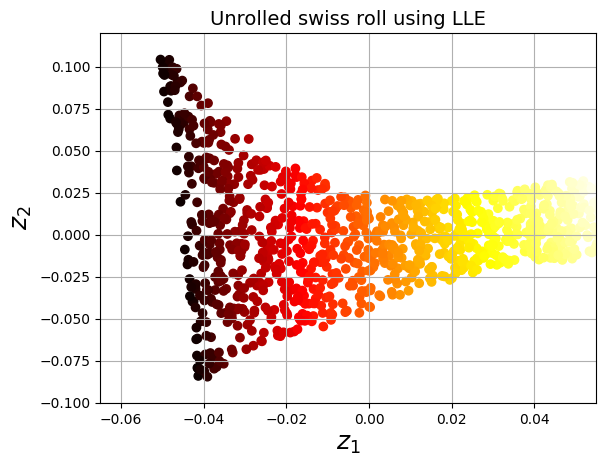

In [33]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
# n_neighbors 代表有多少個被指定成 nearest neighbor 點的點
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

# 由下圖結果可見, 瑞士捲被攤開了, 且實例之間的局部距離關係都大致上有被保留
# 但大尺度的距離就沒有被保留(左邊被拉長, 右邊被擠壓), 不過整體來說還是很好的流形模型

# 其他降維技術

1. Multidimensional Scaling (MDS): 降維的同時, 試著保留實例之間的距離

In [34]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

/Users/chenyanting/Desktop/Machine Learning Study/my_env/lib/python3.10/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


2. Isomap: 將每一個實例連結到最近的鄰點來建立一張圖, 在降維時保留實例之間的geodesic距離

In [35]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

3. t-SNE (t-Distributed Stochastic Neighbor Embedding): 在降維的同時, 試著讓相似的實例彼此靠近

In [36]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

比較 MDS, Isomap, t-SNE 產生的結果

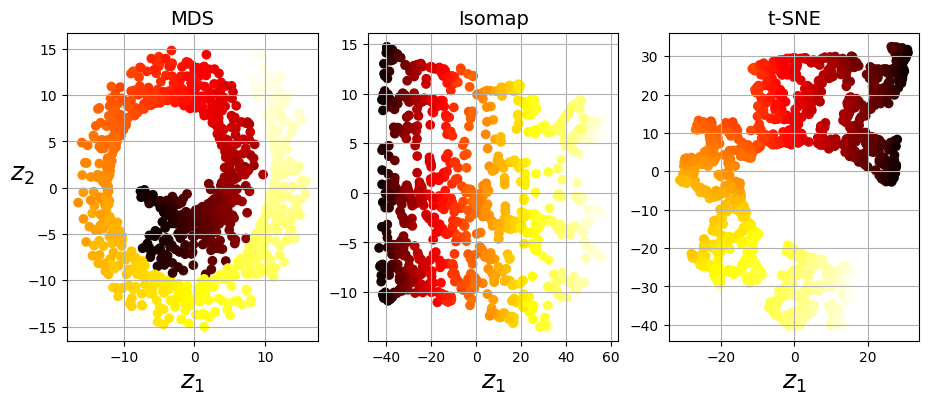

In [37]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()